In [1]:
%load_ext autoreload
%autoreload 2
import sys
import collections
import numpy as np
# sys.path.append("/private/home/alexandrerame/domainbedv2/")
# sys.path.append("/private/home/alexandrerame/slurmconfig/notebook/data")

sys.path.append("/home/rame/domainbedv2/")

from domainbed.codeplot import plot


In [2]:
sys.path.append("/home/rame/trl/examples/sentiment/scripts/gpt-neox-20b_peft/logs")
import logs_posimdb_negimdb, logs_quality_negimdb, logs_toxic_neg, logs_rl_pos_vs_toxic, logs_rl_posimdb_vs_toxic0, logs_rl_pos_vs_quality2, logs_rl_toxic_vs_quality1, logs_rl_toxic_vs_quality2, logs_rl_posimdb_vs_toxic, logs_rl_pos_posimdb

In [3]:
modules = [
    logs_posimdb_negimdb,
    logs_quality_negimdb,
    logs_toxic_neg,
    logs_rl_pos_posimdb, logs_rl_posimdb_vs_toxic, logs_rl_pos_vs_toxic, logs_rl_posimdb_vs_toxic0,
    logs_rl_pos_vs_quality2, logs_rl_toxic_vs_quality1, logs_rl_toxic_vs_quality2
]
for module in modules:
    module.l = []
    for key in sorted(module.d.keys()):
        if 0 <= key <= 1:
            new_d = {"lambda": key}
            new_d["pos0"] = module.d[key][0]["POSITIVE"]
            new_d["posd0"] = module.d[key][0]["POSITIVE"] - module.d[key][0]["NEGATIVE"]
            new_d["pos1"] = module.d[key][1]["POSITIVE"]
            new_d["posd1"] = module.d[key][1]["POSITIVE"] - module.d[key][1]["NEGATIVE"]
            new_d["toxic"] = module.d[key][2]["toxic"]
            new_d["toxicd"] = module.d[key][2]["toxic"] - module.d[key][2]["non-toxic"]
            new_d["quality"] = module.d[key][3]["good"]
            new_d["quality1"] = module.d[key][3]["medium"]
            new_d["qualityd"] = module.d[key][3]["good"] - module.d[key][3]["bad"]
            module.l.append(new_d)

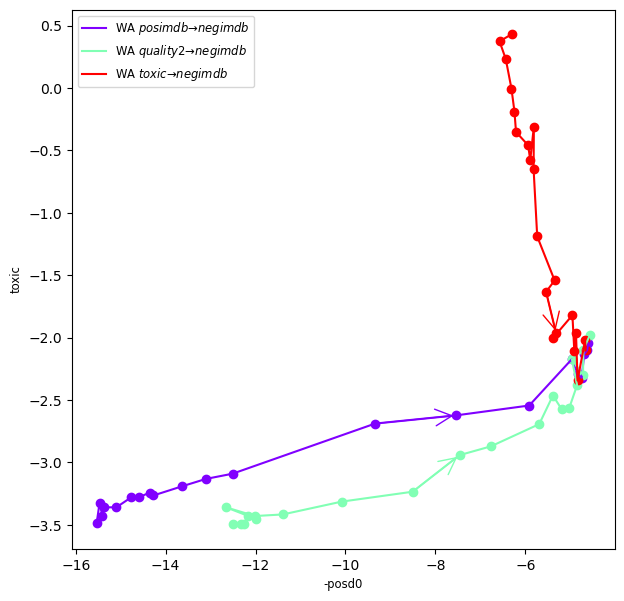

In [7]:
plot.plt.rcParams["figure.figsize"] = (7, 7)
plot.SIZE_AXIS = "small"
plot.SIZE = "small"
fig_dr = plot.plot_key(
    [module.l for module in modules][:3],
    key_x="-posd0",
    key_y="toxic",
    labels=[module.label for module in modules],
    loc="best",
    # keycolor="lambda",
    # colormaps=[
    #     "Reds",
    #     "Purples",
    #     "Oranges",
    #     "Greys",
    #     "Blues",
    #     "Yellows",
    #     "Greens",
    # ],
    linestyles=["solid" for module in modules],
    # linestyles=[ls if ls not in [] else None for ls in [
    #     "solid",
    #     "dashed",
    #     "solid",
    #     "solid",
    # ]],
    connect_points=True,
    order=2,
)